In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import json
import os
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms

In [3]:

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and JSON files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.img_files[idx])
        json_file = img_name.replace('.png', '.json')

        with open(json_file) as f:
            annotations = json.load(f)['annotations']

        # Load image
        image = Image.open(img_name).convert('RGB')

        # Create an empty mask
        mask = Image.new('L', image.size, 0)

        # Create a draw object
        draw = ImageDraw.Draw(mask)

        # Draw polygons or bounding boxes on the mask
        for annotation in annotations:
            if 'polygon' in annotation:  # Check if polygon data exists
                polygon = annotation['polygon']['paths']
                # Convert polygon points into the format expected by PIL.ImageDraw.Draw.polygon (flat list)
                polygon_points = [tuple(point.values()) for path in polygon for point in path]
                draw.polygon(polygon_points, outline=1, fill=1)
            # else: # 'bounding_box' in annotation:  # Fallback to bounding box if no polygon
            #     bbox = annotation['bounding_box']
            #     x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
            #     draw.rectangle([x, y, x+w, y+h], outline=1, fill=1)

        # If using transformations that work on PIL Images (like ToTensor), apply them directly
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [ ]:
# !unzip '/content/drive/MyDrive/EfficientDetDoesEAST.zip' -d '/content/'

In [5]:

# Example usage
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomDataset(root_dir='/content/EfficientDetDoesEAST/dataset_updated', transform=transform)

In [5]:
import json
import os
from PIL import Image, ImageDraw
from torchvision import transforms
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, image_transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and JSON files.
            image_transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.img_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.img_files[idx])
        json_file = img_name.replace('.png', '.json')

        with open(json_file) as f:
            annotations = json.load(f)['annotations']

        # Load image
        image = Image.open(img_name).convert('RGB')

        # Create an empty mask
        mask = Image.new('L', image.size, 0)

        # Create a draw object
        draw = ImageDraw.Draw(mask)

        # Draw polygons on the mask
        for annotation in annotations:
            if 'polygon' in annotation:  # Check if polygon data exists
                polygon = annotation['polygon']['paths']
                polygon_points = [tuple(point.values()) for path in polygon for point in path]
                draw.polygon(polygon_points, outline=1, fill=1)

        # Apply transformations
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return image, mask

# Example usage
image_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    # Add any other image transformations here
])

# Masks generally don't require normalization, but resizing is essential to match image dimensions
mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])


dataset = CustomDataset(root_dir='/content/EfficientDetDoesEAST/dataset_updated', image_transform=image_transform, mask_transform=mask_transform)


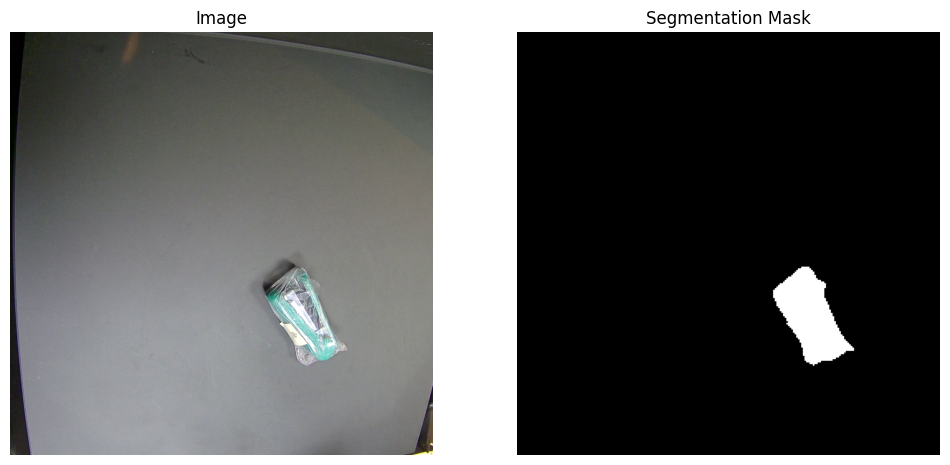

In [6]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Assuming you've defined the CustomDataset class as before and instantiated it as `dataset`

def visualize_sample(dataset, idx):
    # Convert tensor to PIL Image for visualization
    to_pil = ToPILImage()

    # Get the image and mask from the dataset
    img, mask = dataset[idx]

    # Convert tensors back to PIL images (if using ToTensor transform)
    img = to_pil(img)
    mask = to_pil(mask)

    # Create a figure to display the images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')

    plt.show()

# Visualize the first image and its mask
visualize_sample(dataset, 1)

# If you want to visualize a second image, you can call it again with a different index
# visualize_sample(dataset, 1)


In [7]:
cd EfficientDetDoesEAST/

/content/EfficientDetDoesEAST


In [24]:
# pip install kornia

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
import os
import numpy as np
from torch import nn
from effdet.east.model import EfficientDetDoesEAST



In [9]:
# from effdet.segmentation.model import EfficientDetForSemanticSegmentation

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and DataLoader setup
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

# Model setup
# model = EfficientDetForSemanticSegmentation(advprop=True, compound_coef=2)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
class DiceLoss(nn.Module):

    def forward(self, y_true, scores, eps=1e-8):
        # compute the actual dice score
        dims = (1, 2)
        intersection = torch.sum(scores * y_true, dims)
        cardinality = torch.sum(scores + y_true, dims)

        dice_score = 2. * intersection / (cardinality + eps)
        return torch.mean(-dice_score + 1.)

In [11]:
class EffDetSegmentationPart(EfficientDetDoesEAST):

    def forward(self, x):
        _, _, height, width = x.shape
        feats = self.backbone(x)

        scores = self.scores(feats)
        scores = torch.sigmoid(scores)

        score_map = scores[:, 0] # take only the segmentation scores
        return score_map

In [12]:
model = EffDetSegmentationPart(advprop=True, compound_coef=4)



Loaded pretrained weights for efficientnet-b4


In [13]:
loss_fn = DiceLoss()

In [14]:

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    model.backbone.freeze_bn() # freeze BN

    model.zero_grad()
    for imgs, targets in data_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        # loss_dict = model(imgs, targets)  # Adjust according to your model's output
        scores = model(imgs.to(device))
        losses =  loss_fn(scores, targets)
        # losses = sum(loss for loss in loss_dict.values())
        if losses.isnan().item():
            model.zero_grad()
            break
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"Epoch: {epoch}, Loss: {losses.item()}")

In [49]:

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.backbone.backbone_net.requires_grad_(False)
# Optimizer setup
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch)
    # save your model at the end of every epoch

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 0, Loss: 0.999648928642273
Epoch: 0, Loss: 0.9995107054710388
Epoch: 0, Loss: 0.9993288516998291
Epoch: 0, Loss: 0.9993573427200317
Epoch: 0, Loss: 0.9994617104530334
Epoch: 0, Loss: 0.9991093873977661
Epoch: 0, Loss: 0.9991519451141357
Epoch: 0, Loss: 0.9992467761039734
Epoch: 0, Loss: 0.9993894100189209
Epoch: 0, Loss: 0.9991703033447266
Epoch: 0, Loss: 0.9992378950119019
Epoch: 0, Loss: 0.9990195035934448
Epoch: 0, Loss: 0.9991453886032104
Epoch: 0, Loss: 0.9987795948982239
Epoch: 0, Loss: 0.9993076920509338
Epoch: 1, Loss: 0.9997532963752747
Epoch: 1, Loss: 0.999487578868866
Epoch: 1, Loss: 0.999252438545227
Epoch: 1, Loss: 0.9991562366485596
Epoch: 1, Loss: 0.9992965459823608
Epoch: 1, Loss: 0.9989047646522522
Epoch: 1, Loss: 0.9991637468338013
Epoch: 1, Loss: 0.9988503456115723
Epoch: 1, Loss: 0.9992176294326782
Epoch: 1, Loss: 0.9995796084403992
Epoch: 1, Loss: 0.9993427991867065
Epoch: 1, Loss: 0.9989641308784485
Epoch: 1, Loss: 0.9993481636047363
Epoch: 1, Loss: 0.99951

In [16]:
img, mask = dataset[1].img

In [19]:
img.shape, mask.shape

(torch.Size([3, 1024, 1024]), torch.Size([1, 256, 256]))

In [ ]:
model.eval()
with torch.no_grad():
    scores = model(img)

In [31]:
from torchvision import transforms
from PIL import Image
import torch

# Assuming `model` is your trained model

# Put the model in evaluation mode
model.eval()

# Define the transforms. This should match your training transforms as closely as possible.
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Adjust size as per your model's training
    transforms.ToTensor(),
    # If you used normalization in your training, apply the same here
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load an image
image_path = '/content/EfficientDetDoesEAST/dataset_updated/10.png'
image = Image.open(image_path).convert('RGB')

# Apply the transforms
image = transform(image)

# Add a batch dimension (CNNs expect batches)
image = image.unsqueeze(0)

# If using GPU for inference
image = image.cuda()

# Perform the inference
with torch.no_grad():
    output = model(image)

print(output)
# Post-processing
# Depending on your model's output, you might need to apply a threshold or perform other adjustments.
# For example, if your output is a segmentation map with probabilities, you can threshold it to get a binary mask:
threshold = 0.3  # Example threshold
predicted_mask = (output.squeeze() > threshold).cpu().numpy()

# Now, `predicted_mask` contains the predicted segmentation mask for your input image.
# You can further process `predicted_mask` as needed for visualization, analysis, etc.


tensor([[[0.5360, 0.5688, 0.5715,  ..., 0.5713, 0.5674, 0.5370],
         [0.5777, 0.6316, 0.6355,  ..., 0.6353, 0.6297, 0.5797],
         [0.5803, 0.6356, 0.6403,  ..., 0.6401, 0.6341, 0.5825],
         ...,
         [0.5801, 0.6354, 0.6401,  ..., 0.6399, 0.6340, 0.5824],
         [0.5758, 0.6284, 0.6323,  ..., 0.6322, 0.6274, 0.5782],
         [0.5414, 0.5696, 0.5719,  ..., 0.5719, 0.5691, 0.5407]]],
       device='cuda:0')


In [34]:
predicted_mask.shape

(256, 256)

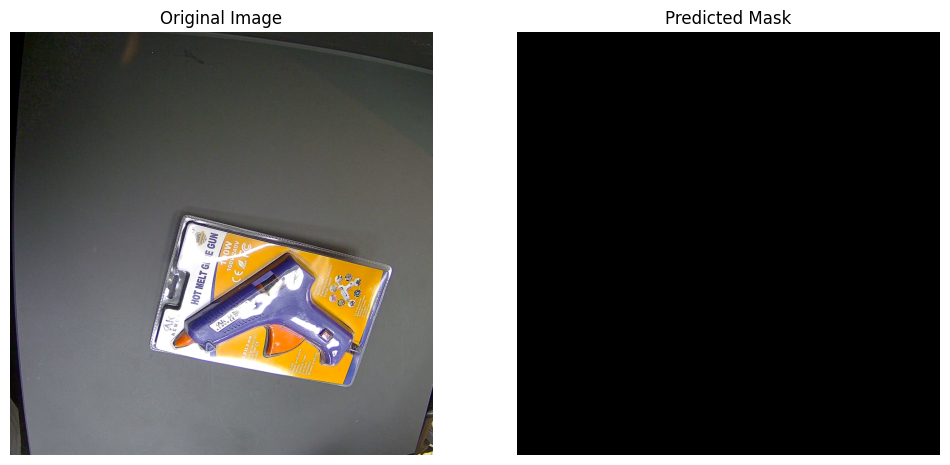

In [29]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the original image for visualization
original_image = Image.open(image_path)

# Ensure the original image and the mask are numpy arrays for plotting
original_image_np = np.array(original_image)
predicted_mask_np = predicted_mask.astype(np.float32)  # Ensuring the mask is float for visualization

# Creating a figure to display the images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
ax[0].imshow(original_image_np)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Display the predicted mask
# If the predicted mask is not binary (e.g., multi-class), you might need a colormap, e.g., 'viridis'
ax[1].imshow(predicted_mask_np, cmap='gray')
ax[1].set_title('Predicted Mask')
ax[1].axis('off')

plt.show()


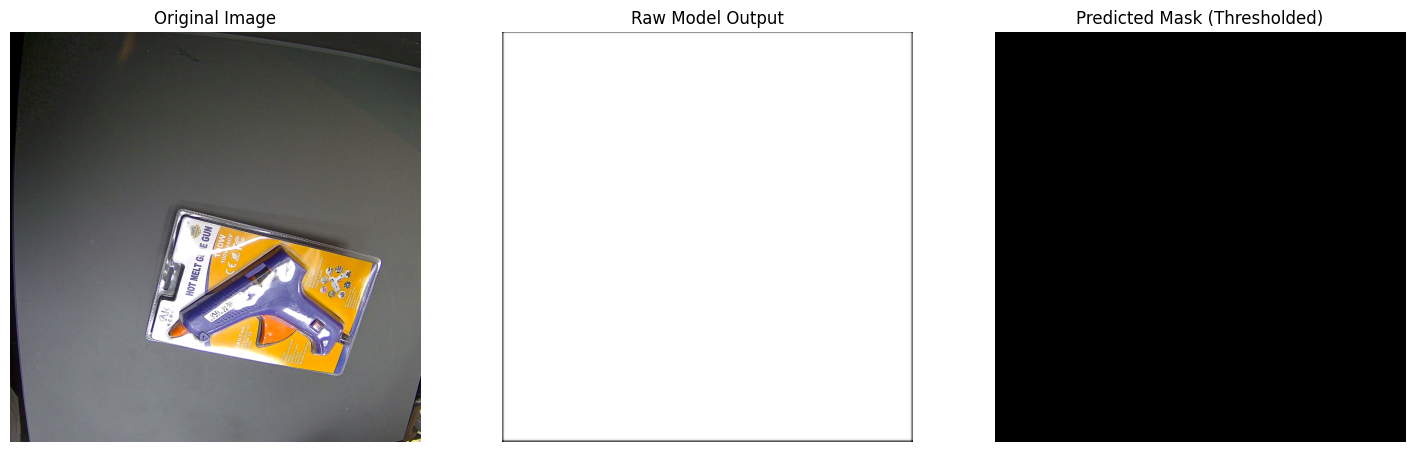

Raw output - Min: 0.5359589 Max: 0.64085144
Threshold used: 0.3


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `output` is the raw output from the model before any thresholding
output_np = output.squeeze().cpu().numpy()  # Adjust depending on your model's output shape

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(original_image_np)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Visualize the raw model output
ax[1].imshow(output_np, cmap='gray')
ax[1].set_title('Raw Model Output')
ax[1].axis('off')

# Visualize the thresholded mask
ax[2].imshow(predicted_mask_np, cmap='gray')
ax[2].set_title('Predicted Mask (Thresholded)')
ax[2].axis('off')

plt.show()

# Print out some diagnostic information
print("Raw output - Min:", np.min(output_np), "Max:", np.max(output_np))
print("Threshold used:", threshold)


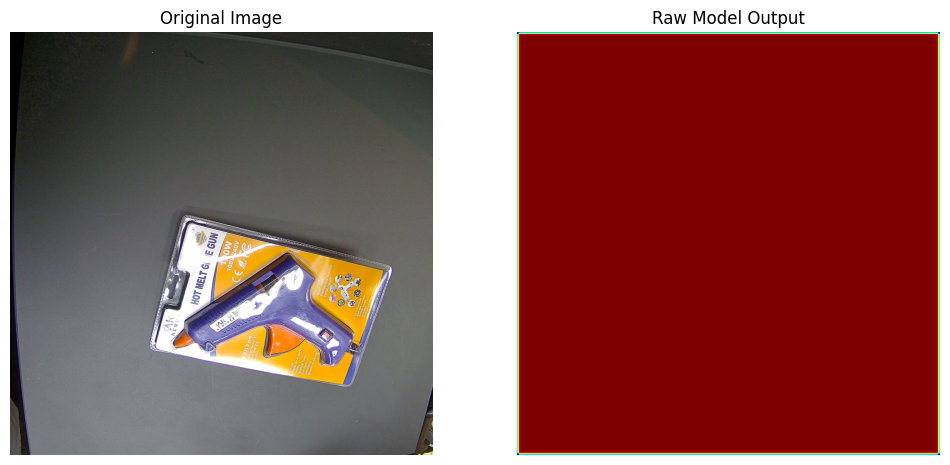

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `output` is your raw model output
output_np = output.squeeze().cpu().numpy()  # Adjust based on your model's output shape

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(original_image_np)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Use a colormap to visualize the raw output; this can help make subtle variations more visible
# 'jet' is just an example; 'viridis', 'plasma', 'inferno', etc., could also be interesting to explore
ax[1].imshow(output_np, cmap='jet')
ax[1].set_title('Raw Model Output')
ax[1].axis('off')

plt.show()



In [43]:
pred = (1*(output > 0.5)).type(torch.uint8)

In [48]:
if 1 in pred:
  print(0)

0


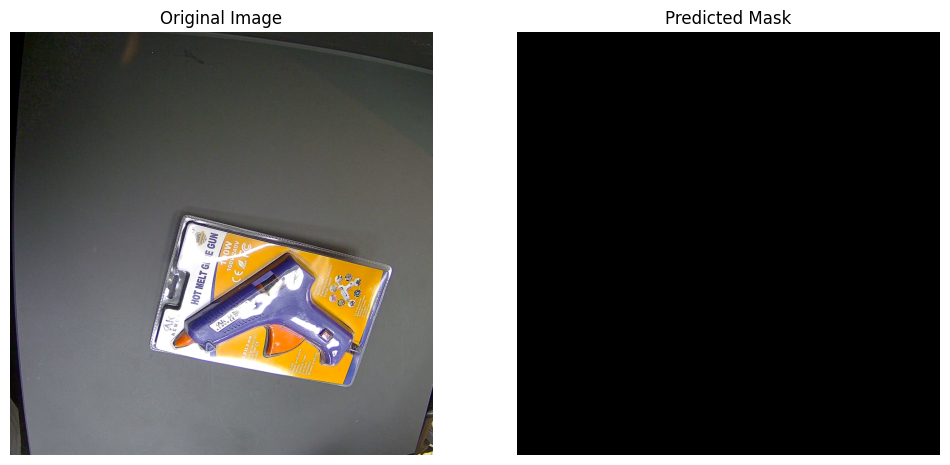

In [39]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Assuming 'output' is your model's output tensor
# Apply threshold to create a binary mask
pred = (1 * (output > 0.5)).type(torch.uint8)
pred_np = pred.squeeze().cpu().numpy()  # Convert to numpy array for visualization

# Load the original image for comparison
original_image = Image.open(image_path)
original_image_np = np.array(original_image)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
ax[0].imshow(original_image_np)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Predicted Mask
ax[1].imshow(pred_np, cmap='gray')  # Visualizing the binary mask
ax[1].set_title('Predicted Mask')
ax[1].axis('off')

plt.show()


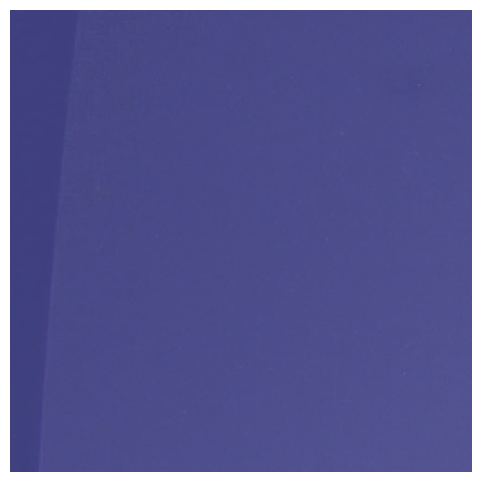

In [42]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def visualize_single_image(img, mask):
    """
    Visualize a single image with its corresponding segmentation mask overlaid.

    Parameters:
    - img (Tensor): The image tensor, shape [C, H, W].
    - mask (Tensor): The mask tensor, shape [H, W] or [1, H, W].
    """
    # Normalize the image to [0, 1] if it's not already
    img = F.to_pil_image((img + 1)/2)  # Assuming img is in [-1, 1]

    # Convert mask to a PIL image for easy overlay (ensure it's binary, you might not need this step if it's already in the correct format)
    mask = F.to_pil_image(mask)

    plt.figure(figsize=(6, 6))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes for better visualization

    # Overlay the mask with transparency
    plt.imshow(mask, cmap='jet', alpha=0.5)  # 'jet' is used here for visualization, adjust as necessary

    plt.show()

img , mask = dataset[1]

# Example usage:
# Assuming `single_img` and `single_mask` are your image and mask tensors, respectively
visualize_single_image(img, pred)
